This kernel is inspired by Heng's [discussion](https://www.kaggle.com/c/severstal-steel-defect-detection/discussion/106462#latest-618693), which is about [HRNet-Semantic-Segmentation](https://arxiv.org/abs/1904.04514)
![](https://raw.githubusercontent.com/HRNet/HRNet-Semantic-Segmentation/master/figures/seg-hrnet.png?generation=1565963628491533&amp;alt=media)


In [ ]:
!git clone https://github.com/georgepsh/OCRForClothes

Cloning into 'OCRForClothes'...
remote: Enumerating objects: 3159, done.
remote: Total 3159 (delta 0), reused 0 (delta 0), pack-reused 3159
Receiving objects: 100% (3159/3159), 313.32 MiB | 35.36 MiB/s, done.
Resolving deltas: 100% (582/582), done.
Checking out files: 100% (3140/3140), done.


In [ ]:
!nvidia-smi

Thu Jun 25 07:16:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    35W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from OCRForClothes.HRNet.c1_decoder import get_decoder, C1DeepSup
from OCRForClothes.HRNet.hrnet import get_encoder
from OCRForClothes.HRNet.resnet import resnet18, resnet50
from OCRForClothes.HRNet.model import Resnet_OCR
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
import torch.nn as nn
import torch
import numpy as np
import cv2
from PIL import Image
import scipy.io
import matplotlib.pylab as plt
import glob
from tqdm import tqdm
import pickle as pkl

In [ ]:
device = torch.device('cuda')   

In [ ]:
def transform(image, size):
    resize = transforms.Compose([transforms.Resize(size), transforms.ToTensor()])
    return resize(Image.fromarray(np.uint8(image))).unsqueeze(0)

In [ ]:
def show(output, colors):
    final = output[0].cpu().detach().numpy()
    classes = np.argmax(final, axis=0)
    mask = colors[classes]
    plt.imshow(mask)
    plt.show()

In [ ]:
encoder = resnet18('OCRForClothes/resnet18-imagenet.pth')

In [ ]:
decoder = get_decoder(59, 960, '')

In [ ]:
size = (800, 544)
size_label = (200, 136)

In [ ]:
colors = scipy.io.loadmat('OCRForClothes/color150.mat')['colors']

In [ ]:
output_folder = f'OCRForClothes/data/annotations/pixel-level/'
input_folder = f'OCRForClothes/data/photos/'
num = 1004

In [ ]:
inputs = torch.cat([transform(Image.open(x), size) for x in sorted(glob.glob(f'{input_folder}*.jpg'))[:num]])

In [ ]:
labels = torch.cat([(255 * transform(scipy.io.loadmat(x)['groundtruth'], size_label)).type(torch.LongTensor) 
          for x in sorted(glob.glob(f'{output_folder}*.mat'))[:num]])

In [ ]:
train_dataset, test_dataset = TensorDataset(inputs[:803], labels[:803]), TensorDataset(inputs[803:], labels[803:])

In [ ]:
model = Resnet_OCR(encoder, decoder, size).to(device)
# model.EncoderDecoder.load_state_dict(torch.load('model.pkl'))

In [ ]:
def measure_accuracy(model, dataset):
    dataloader = DataLoader(dataset, 1, shuffle=False)
    count = 0
    correct = 0
    for data, target in dataloader:
        prediction = model(data.to(device), ocr=True)[1][0].cpu().detach().numpy()
        classes = np.argmax(prediction, axis=0)
        count += classes.shape[0] * classes.shape[1]
        comparison = (classes == target[0, 0].detach().numpy()).astype(int).flatten()
        correct += sum(comparison)
    return correct / count

In [ ]:
def train(model, train_dataset, test_dataset, epochs=1, batch_size=64, upd_freq=4):
    dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
    optimizer = optim.Adam(model.parameters(), 3e-4)
    model.train()
    criterion = nn.NLLLoss(ignore_index=-1)
    losses = []
    accs = []
    for e in range(epochs):
        epoch_loss = 0
        count = 0
        for data, target in tqdm(dataloader, total=len(dataloader)):
            data, target = data.to(device), target.to(device)
            
            prediction = model(data)
            out_aux = prediction[0]
            out = prediction[1]

            soft_region_loss = criterion(out_aux, target.squeeze(1))
            ocr_loss = criterion(out, target.squeeze(1))
            loss = soft_region_loss + ocr_loss
            loss.backward()
            if (count + 1) // upd_freq == 0 or (count + 1) == len(dataloader):
                optimizer.step()
                optimizer.zero_grad()
            count += 1
            epoch_loss += loss
        losses.append(epoch_loss.item() / count)
        name = 'model_ocr' + str(e+1) + 'pkl'
        torch.save(model.state_dict(), name)
        accs.append(measure_accuracy(model, test_dataset))
        print(f'epoch {e+1} loss: {epoch_loss.item() / count}')
        print(f'epoch {e+1} accuracy: {accs[-1]}')
    return losses, accs

In [ ]:
losses, accuracies = train(model, train_dataset, test_dataset, epochs=30, batch_size=4, upd_freq=4)

  0%|          | 0/201 [00:00<?, ?it/s]

epoch 1 loss: 7.977610725668533
epoch 1 accuracy: 0.5576986391571555


  0%|          | 0/201 [00:00<?, ?it/s]

epoch 2 loss: 7.03471776857898
epoch 2 accuracy: 0.6904783069944396


  0%|          | 0/201 [00:00<?, ?it/s]

epoch 3 loss: 6.543749149759018
epoch 3 accuracy: 0.7202681445712613


  0%|          | 0/201 [00:00<?, ?it/s]

epoch 4 loss: 6.142221023787314
epoch 4 accuracy: 0.7494882206613989


  0%|          | 0/201 [00:00<?, ?it/s]

epoch 5 loss: 5.821251408970771
epoch 5 accuracy: 0.7693899985367281


  0%|          | 0/201 [00:00<?, ?it/s]

epoch 6 loss: 5.571221650536381
epoch 6 accuracy: 0.7724690883816213


  0%|          | 0/201 [00:00<?, ?it/s]

epoch 7 loss: 5.371623935984142
epoch 7 accuracy: 0.7835041703248463


  0%|          | 0/201 [00:00<?, ?it/s]

epoch 8 loss: 5.250530793299129
epoch 8 accuracy: 0.7878226514486392


 65%|██████▍   | 130/201 [05:08<02:49,  2.39s/it]

In [ ]:
torch.save(model.state_dict(), 'model_ocr.pkl')

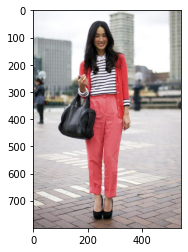

In [ ]:
num = 96
example = train_dataset[num][0].unsqueeze(0)
example.shape
plt.imshow(example[0].permute((1, 2, 0)))

(200, 136, 3)


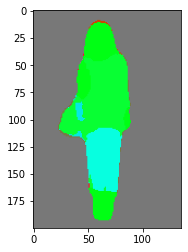

In [ ]:
prediction = model(example.to(device), ocr=True, segSize=False)
show(prediction[1], colors)

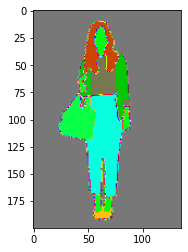

In [ ]:
lab = labels[num][0]
truth = colors[lab]
plt.imshow(truth, cmap='gray')